In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [8]:
import pickle
import numpy as np
import pandas as pd
from glob import glob
import warnings
from copy import deepcopy
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import chi2, gaussian_kde
from scipy.special import erfinv, erf
from scipy.optimize import fmin_l_bfgs_b
import seaborn as sns

from settings import poles, ngc1068, txs0506
from tools import get_mids, array_source_interp
from fluxes import (
    atmo_background,
    astro_flux,
    plot_spectrum,
    power_law,
    cut_off,
    parabola_index
)



In [9]:
e_smearing_files = sorted(glob("../resources/*energy_smearing_kde.pckl"))
sigma5 = 1 - erf(5 / np.sqrt(2))


In [10]:
matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../style.mplstyle")
colorlist = plt.rcParams["axes.prop_cycle"].by_key()["color"]
warnings.filterwarnings("ignore")


# Get the effective areas based on "alternative_plenum_aeff.ipynb"

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [5]:
# use only upgoing data to mimick up-going muon track data set
with open("../resources/tabulated_logE_sindec_aeff_upgoing.pckl", "rb") as f:
    logE_bins, sindec_bins, aeff_2d = pickle.load(f)

logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

ra_bins = np.linspace(0, np.pi * 2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]
print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")


40 log_10(energy) bins
50 declination bins


# Background

In [6]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_conv"])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))


# Energy smearing with KDE

## Load matrices

In [7]:
# energy smearing matrix
with open("../resources/energy_smearing_kde.pckl", "rb") as f:
    normed_kvals, logE_reco_bins = pickle.load(f)
# normalize per bin in true energy
normed_kvals = normed_kvals / np.sum(normed_kvals, axis=0)
logE_reco_mids = get_mids(logE_reco_bins)

# # artificial smearing matrix
# with open("../resources/artificial_energy_smearing_kde.pckl", "rb") as f:
#     artificial_normed_kvals, _ = pickle.load(f)

# artificial, improved smearing matrix
with open("../resources/improved_0.5_artificial_energy_smearing_kde.pckl", "rb") as f:
    artificial_normed_kvals, _ = pickle.load(f)

## original and artificial energy resolution

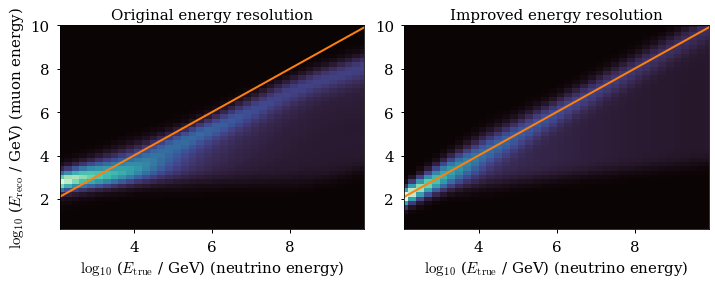

In [8]:
# logE_mids are the same as for effective area binning
egrid_true, egrid_reco = np.meshgrid(logE_mids, logE_reco_mids)

f, axes = plt.subplots(ncols=2, figsize=(10, 4))

axes[0].grid(False)
axes[0].pcolormesh(egrid_true, egrid_reco, normed_kvals)
# f.colorbar()
axes[0].plot([1, 10], [1, 10], color="tab:orange")
axes[0].set_ylim(np.min(egrid_reco), np.max(egrid_reco))
axes[0].set_xlim(np.min(egrid_true), np.max(egrid_true))
axes[0].set_title("Original energy resolution")
axes[0].set_ylabel(r"$\log_{10}$ ($E_{\rm reco}$ / GeV) (muon energy)")
axes[0].set_xlabel(r"$\log_{10}$ ($E_{\rm true}$ / GeV) (neutrino energy)")

## Artificial
axes[1].grid(False)
axes[1].pcolormesh(egrid_true, egrid_reco, artificial_normed_kvals)
# f.colorbar()
axes[1].plot([1, 10], [1, 10], color="tab:orange")
axes[1].set_ylim(np.min(egrid_reco), np.max(egrid_reco))
axes[1].set_xlim(np.min(egrid_true), np.max(egrid_true))
axes[1].set_title("Improved energy resolution")
# axes[1].set_ylabel(r"$\log_{10}$ ($E_{\rm reco}$ / GeV) (muon energy)")
axes[1].set_xlabel(r"$\log_{10}$ ($E_{\rm true}$ / GeV) (neutrino energy)")
f.tight_layout()
f.savefig("../plots/energy_resolution_comparison.pdf", bbox_inches="tight")

# NGC1068 - source parameters

In [11]:
# livetime of 10yr PS data
lt_10yr = (376.4 + 352.6 + 316.0 + 332.9 + 2198.2) * 24 * 3600
lt_kde = LIVETIME = 3186 * 24 * 3600
# 10yr PS PAPER PARAMETERS
GAMMA_NGC = 3.2
PHI_NGC = 5E-14 
E0_NGC = 1E3

# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt("../resources/ngc_paper_68_contour.txt")
phi_c_68 /= 1E11
# gamma_c_68, phi_c_68 = np.loadtxt("../resources/tenyr_paper_68_contour.txt")

# analysis region in distance to source
delta_psi = 2

In [12]:
## check event numbers
aeff_factor_signal = (
    array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids) * LIVETIME * ewidth
)
k_s = astro_flux(
    "powerlaw",
    aeff_factor_signal,
    emids,
    E0_NGC,
    GAMMA_NGC,
    1,
    phi_0=PHI_NGC,
)
print(np.sum(k_s))


79.47365242225797


## PL+Cut: source parameters

In [13]:
# parabola parameters
Alpha_NGC = 1
Beta_NGC = 1
E_para_norm = 3E2

# cutoff parameters
Gamma_cut = 2.0
logE_cut = 3.7 # log10 (Ecut / GeV)



### scale the fluxes such that the event numbers match


In [14]:
aeff_factor_signal = array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids) * LIVETIME * ewidth
astro_ev_sum_pl = np.sum(
    astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_NGC,
        GAMMA_NGC,
        1,
        phi_0=PHI_NGC,
        #smear_energy=False,
    )
)

# parabola
astro_ev_sum_para = np.sum(
    astro_flux(
        "parabola",
        aeff_factor_signal,
        emids,
        E_para_norm,
        Alpha_NGC,
        1,
        Beta_NGC,
        phi_0=PHI_NGC,
        #smear_energy=False,
    )
)
# match event numbers
flux_scaling_para = astro_ev_sum_pl / astro_ev_sum_para
print("flux_scaling_para", flux_scaling_para)

# cutoff
astro_ev_sum_cut = np.sum(
    astro_flux(
        "powerlaw with cutoff",
        aeff_factor_signal,
        emids,
        E0_NGC,
        Gamma_cut,
        1,
        logE_cut,
        phi_0=PHI_NGC,
        #smear_energy=False,
    )
)
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("flux_scaling_cut", flux_scaling_cut)


flux_scaling_para 6.221046405749047
flux_scaling_cut 0.9676925453516532



### Plot flux and event expectation


powerlaw with cutoff 79.47365242225797
power law: 79.47365242225797


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


powerlaw with cutoff 79.47365242225797
power law: 79.47365242225796


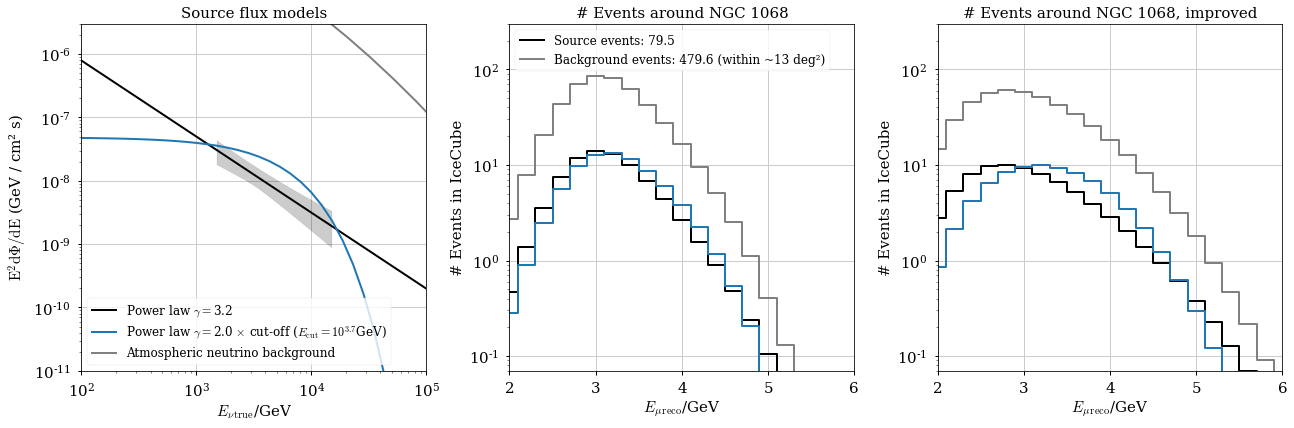

In [15]:
sq_deg = np.pi * delta_psi**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

pl = power_law(x_evals, E0_NGC, GAMMA_NGC, PHI_NGC)
cut = power_law(x_evals, E0_NGC, Gamma_cut, PHI_NGC * flux_scaling_cut) * cut_off(
    x_evals, 10**logE_cut
)
# para_idx = parabola_index(Alpha_NGC, Beta_NGC, x_evals, E_para_norm)
# para = power_law(x_evals, E_para_norm, para_idx, PHI_NGC * flux_scaling_para)

f, axes = plt.subplots(ncols=3, figsize=(18, 6))
ax = axes[0]
ax.set_title("Source flux models")

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# without energy range interval
# x_cont = np.logspace(1.9, 5.1, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, E0_NGC, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)

ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"Power law $\gamma=${GAMMA_NGC}",
    color="k",
    alpha=1,
)

# ax.plot(x_evals, para * (x_evals**y_scaling), label="Log-Parabola", color="darkred")
ax.plot(
    x_evals,
    cut * (x_evals**y_scaling),
    label=rf"Power law $\gamma=${Gamma_cut} $\times$ cut-off ($E_{{\rm cut}}=10^{{{logE_cut:1.1f}}}$GeV)",
    color="tab:blue",
)
ax.plot(
    emids,
    array_source_interp(ngc1068.dec.rad, spl_vals.T, sindec_mids).T
    * (emids**y_scaling),
    label="Atmospheric neutrino background",
    color="gray",
)

ax.set_yscale("log")
ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)")
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV")
ax.set_ylim(1e-11, 3e-6)
# ax.set_ylim(3e-6, 1e-3)
ax.set_xlim(1e2, 1e5)
ax.legend(loc=3, fontsize=12)


### plot Event numbers in E_reco
for ii, nkv in enumerate([normed_kvals, artificial_normed_kvals]):
    ax = axes[1 + ii]
    ident = "IceCube"
    aeff_factor_bckg = (
        array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids)
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    )
    aeff_factor_signal = (
        array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids)
        * LIVETIME
        * ewidth
    )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    use_e_reco = True
    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(ngc1068.dec.rad, spl_vals.T, sindec_mids).T,
        normed_kvals=nkv,
    )

    # cutoff
    k_s_cut = astro_flux(
        "powerlaw with cutoff",
        aeff_factor_signal,
        emids,
        E0_NGC,
        Gamma_cut,
        flux_scaling_cut,
        logE_cut,
        normed_kvals=nkv,
        phi_0=PHI_NGC,
    )
    print("powerlaw with cutoff", np.sum(k_s_cut))

    # powerlaw
    k_s_pl = astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_NGC,
        GAMMA_NGC,
        1,
        normed_kvals=nkv,
        phi_0=PHI_NGC,
    )
    print("power law:", np.sum(k_s_pl))

    evals = logE_reco_mids
    _ = plot_spectrum(
        evals,
        [
            k_s_pl,
            k_s_cut,
            k_b,
        ],
        [
            f"Source events: {np.sum(k_s_pl):1.1f}" if ii == 0 else "",
            "",
            f"Background events: {np.sum(k_b):1.1f} (within ~{sq_deg:1.0f} deg²)"
            if ii == 0
            else "",
        ],
        "# Events around NGC 1068" if ii == 0 else "# Events around NGC 1068, improved",
        f,
        ax,
        xlim=(2, 6),
        ylim=(7e-2, 3e2),
        color=["k", "tab:blue", "gray"],  # "darkred",
        xlabel=r"$E_{\mu \, \rm reco}$/GeV",
        ylabel="# Events in IceCube",
    )
    if ii == 1:
        ax.get_legend().remove()
    else:
        ax.legend(loc=2, fontsize=12)

f.savefig("../plots/ngc_spectral.pdf", bbox_inches="tight")


# PSF-Energy functions from the smearing matrix
$f_x(x) = kde(x)$ with $ x = \log_{10}(y) \Leftrightarrow y = 10^x$

Transform: $z = y² = 10^{(2\cdot x)}$ with $ x = \frac{\log_{10}(z)}{2} := g(z)$

$\Rightarrow f_z(z) = | \frac{d}{dz} g(z) | \cdot f(g(z)) = \frac{1}{2\cdot z \cdot \log(10)} kde(\frac{\log_{10}(z)}{2})$

In [21]:
public_data_hist = np.genfromtxt("../resources/IC86_II_smearing.csv", skip_header=1)

logE_sm_min, logE_sm_max = public_data_hist[:, 0], public_data_hist[:, 1]
logE_sm_mids = (logE_sm_min + logE_sm_max) / 2.0
dec_sm_min, dec_sm_max = public_data_hist[:, 2], public_data_hist[:, 3]
dec_sm_mids = (dec_sm_min + dec_sm_max) / 2.0
log_psf_min, log_psf_max = np.log10(public_data_hist[:, 6]), np.log10(
    public_data_hist[:, 7]
)
psf_mids = (public_data_hist[:, 6] + public_data_hist[:, 7]) / 2.0
log_psf_mids = np.log10(psf_mids)
fractional_event_counts = public_data_hist[:, 10]


## Full 2D psi-energy LLH of sources around the horizon

### select the right declination bin for sources around the horizon


In [27]:
## np.unique(dec_sm_min/max) -> [-90, -10, 10, +90]
mask = dec_sm_mids == 0 # that's valid for both ngc1068 and txs0506


In [28]:
## set up the psi2-energy function and binning
e_psi_kdes = gaussian_kde(
    (logE_sm_mids[mask], log_psf_mids[mask]), weights=fractional_event_counts[mask]
)

# psi² representation
delta_psi = 2
bins_per_psi2 = 25
psi2_bins = np.linspace(0, delta_psi**2, delta_psi**2 * bins_per_psi2 + 1)
psi2_mids = get_mids(psi2_bins)
log_psi_mids = np.log10(np.sqrt(psi2_mids))
# KDE was produced in log(E_true) and log(Psi)
e_eval, psi_eval = np.meshgrid(logE_mids, log_psi_mids)
psi_kvals = e_psi_kdes([e_eval.flatten(), psi_eval.flatten()]).reshape(
    len(log_psi_mids), len(logE_mids)
)

# new grid for analysis in psi^2 and e_reco after energy smearing
e_grid, psi_grid = np.meshgrid(logE_mids, psi2_mids)
e_psi2_grid = psi_kvals / psi_grid / 2 / np.log(10)
# normalize per energy to ensure that signal event numbers are not changed
e_psi2_grid /= np.sum(e_psi2_grid, axis=0)
bckg_grid = np.ones_like(e_psi2_grid)
bckg_grid /= np.sum(bckg_grid, axis=0)


## Set up LLH function

In [37]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    src_dec,
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal spectral index
    x[2]: signal normalization scaling

    see 'astro_flux' for further shapes and parameters

    mu_b_base: effective area factor for background
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape, default 'powerlaw'
    """

    mu_b = atmo_background(
        mu_b_base * x[0],
        array_source_interp(src_dec, spl_vals.T, sindec_mids).T,
        normed_kvals=normed_kvals,
    )
    mu_s = astro_flux(
        shape, mu_s_base, emids, e_0, *x[1:], phi_0=phi_0, normed_kvals=normed_kvals
    )
    mu_i = mu_s + mu_b

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


# NGC 1068

### Significance test Background vs. Background + Signal

In [39]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids)
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

    aeff_factor_signal = (
        array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids)
        * LIVETIME
        * ewidth
        * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids)
            * LIVETIME
            * ewidth
            * e_psi2_grid
        )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(ngc1068.dec.rad, spl_vals.T, sindec_mids).T,
    )
    k_s = astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_NGC,
        GAMMA_NGC,
        1,
        phi_0=PHI_NGC,
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))
    dct = dict(
        mu_b_base=mu_b_base,
        mu_s_base=mu_s_base,
        k_i=k_i,
        e_0=E0_NGC,
        phi_0=PHI_NGC,
        normed_kvals=normed_kvals,
        src_dec=ngc1068.dec.rad,
    )
    # fix signal contribution to 0
    local_llh = lambda x: ps_llh_2d_composite((x[0], 3, 0), shape="powerlaw", **dct)
    global_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.2,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.2, 3.0, 1.2),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print("")

    # plt.figure()
    # plt.title(ident)
    # plt.plot(psi2_mids, np.sum(k_s, axis=-1), ds="steps-mid", label="Signal expectation")
    # plt.plot(psi2_mids, np.sum(k_b, axis=-1), ds="steps-mid", label="Uniform bckg expectation")
    # plt.xlabel(r"($\Psi$/deg)²")
    # plt.ylabel("events per bin")
    # plt.xlim(0, 4)
    # #plt.ylim(0, 13)
    # plt.legend()


IceCube
Asimov data sum:
Background: 479.55085343059574
Signal: 79.47365242225797
Atmo-only normalization: [1.16572483]
Signal fit parameters: [1.00000485 3.19996494 0.99994366]
-2 Delta LLH: 17.924394438676245
P-VALUE: 0.00012816433896947822 SIGNIFICANCE: 3.82995952304137

Plenum-1
Asimov data sum:
Background: 2013.974104006386
Signal: 335.8922827691626
Atmo-only normalization: [1.1667808]
Signal fit parameters: [1.00000748 3.19998283 0.99994934]
-2 Delta LLH: 71.23511631388828
P-VALUE: 3.4000948590740596e-16 SIGNIFICANCE: 8.125890664701908

Plenum-2
Asimov data sum:
Background: 5119.902171630979
Signal: 850.6227767910163
Atmo-only normalization: [1.16614045]
Signal fit parameters: [1.00000355 3.19999155 0.99998012]
-2 Delta LLH: 187.30259355023736
P-VALUE: 2.1269563999652924e-41 SIGNIFICANCE: inf



### Significance test Background vs. Background + Signal with improved energy resolution

In [41]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids)
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

    aeff_factor_signal = (
        array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids)
        * LIVETIME
        * ewidth
        * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids)
            * LIVETIME
            * ewidth
            * e_psi2_grid
        )
    for ef in e_smearing_files:
        # energy smearing matrix
        with open(ef, "rb") as f:
            nkv, _ = pickle.load(f)
        # normalize per bin in true energy
        nkv = nkv / np.sum(nkv, axis=0)
        es_ident = ef.split("/")[-1].split("_energy")[0]
        print(es_ident)

        # model expectation for fitting
        mu_b_base = deepcopy(aeff_factor_bckg)
        mu_s_base = deepcopy(aeff_factor_signal)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(ngc1068.dec.rad, spl_vals.T, sindec_mids).T,
            normed_kvals=nkv,
        )
        k_s = astro_flux(
            "powerlaw",
            aeff_factor_signal,
            emids,
            E0_NGC,
            GAMMA_NGC,
            1,
            phi_0=PHI_NGC,
            normed_kvals=nkv,
        )
        k_i = k_s + k_b

        # define the fitting functions with all parameters
        # background only, 1 free parameter
        dct = dict(
            mu_b_base=mu_b_base,
            mu_s_base=mu_s_base,
            k_i=k_i,
            e_0=E0_NGC,
            phi_0=PHI_NGC,
            normed_kvals=nkv,
            src_dec=ngc1068.dec.rad,
        )
        # fix signal contribution to 0
        local_llh = lambda x: ps_llh_2d_composite((x[0], 3, 0), shape="powerlaw", **dct)
        global_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
        # ... and fit both hypotheses!
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )
        print("Atmo-only normalization:", out_bckg[0])

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 3.0, 1.2),
            approx_grad=True,
        )
        print("Signal fit parameters:", out_comp[0])
        # print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

        # calculate p-value and significance with Wilks'
        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = erfinv(1 - pval) * np.sqrt(2)
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print("")


IceCube
artificial
Atmo-only normalization: [1.16572568]
Signal fit parameters: [0.99999557 3.19996579 0.9999436 ]
P-VALUE: 0.00013508521676656513 SIGNIFICANCE: 3.816998087623504

energy_smearing_kde.pckl
Atmo-only normalization: [1.16572483]
Signal fit parameters: [1.00000485 3.19996494 0.99994366]
P-VALUE: 0.00012816433896947822 SIGNIFICANCE: 3.82995952304137

idealized_artificial
Atmo-only normalization: [1.16572528]
Signal fit parameters: [0.99998716 3.19999231 0.99998334]
P-VALUE: 9.972170027124674e-05 SIGNIFICANCE: 3.8912680279744216

improved_0.05_artificial
Atmo-only normalization: [1.16572527]
Signal fit parameters: [0.99998507 3.19999688 0.9999995 ]
P-VALUE: 9.89017811105944e-05 SIGNIFICANCE: 3.8932704633382604

improved_0.1_artificial
Atmo-only normalization: [1.16572528]
Signal fit parameters: [0.99998424 3.20001272 1.00001868]
P-VALUE: 9.814781945927879e-05 SIGNIFICANCE: 3.8951256950675988

improved_0.2_artificial
Atmo-only normalization: [1.1657254]
Signal fit parameters:

## 1D scan of power-law parameters

In [42]:
idents = ["IceCube", "Plenum-1", "Plenum-2", "Gen-2"]
num = 50
gamma_astro_scaling = np.linspace(2.5, 3.8, num=num + 1)
astro_scaling = np.logspace(-1.5, 0.3, num=num)
bf_SPL = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}}
local_SPL_gamma_scan = {"ts": {}, "conv": {}, "phi_astro": {}}
local_SPL_phi_scan = {"ts": {}, "conv": {}, "gamma": {}}
shape = "powerlaw"

for ident in idents:
    print(ident)
    for kvi in ["standard", "improved"]:
        print(kvi)
        nkv = normed_kvals if kvi == "standard" else artificial_normed_kvals

        aeff_factor_bckg = (
            array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid
        if "Plenum" in ident:
            aeff_factor_bckg += (
                array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids)
                * LIVETIME
                * ewidth
                * (np.deg2rad(delta_psi) ** 2)
                * np.pi  # solid angle approx.
            ) * bckg_grid

        aeff_factor_signal = (
            array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids)
            * LIVETIME
            * ewidth
            * e_psi2_grid
        )
        if "Plenum" in ident:
            aeff_factor_signal += (
                array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids)
                * LIVETIME
                * ewidth
                * e_psi2_grid
            )
        # model expectation for fitting
        mu_b_base = deepcopy(aeff_factor_bckg)
        mu_s_base = deepcopy(aeff_factor_signal)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(ngc1068.dec.rad, spl_vals.T, sindec_mids).T,
            normed_kvals=nkv,
        )
        k_s = astro_flux(
            "powerlaw",
            aeff_factor_signal,
            emids,
            E0_NGC,
            GAMMA_NGC,
            1,
            phi_0=PHI_NGC,
            normed_kvals=nkv,
        )
        k_i = k_s + k_b

        print("Asimov data sum:")
        print("Background:", np.sum(k_b))
        print("Signal:", np.sum(k_s))

        ## global minimum
        dct = dict(
            mu_b_base=mu_b_base,
            mu_s_base=mu_s_base,
            k_i=k_i,
            e_0=E0_NGC,
            phi_0=PHI_NGC,
            normed_kvals=nkv,
            src_dec=ngc1068.dec.rad,
        )
        global_llh = lambda x: ps_llh_2d_composite(
            x, shape="powerlaw", **dct
        )
        out = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 2.8, 1.2),
            approx_grad=True,
        )
        if out[2]["warnflag"] != 0:
            print("WARNING!!")
        print("bf param:", out[0])

        bf_SPL["ts"][ident + kvi] = out[1]
        bf_SPL["conv"][ident + kvi] = out[0][0]
        bf_SPL["gamma"][ident + kvi] = out[0][1]
        bf_SPL["phi_astro"][ident + kvi] = out[0][2]

        print("starting local gamma scan...")
        local_SPL_gamma_scan["ts"][ident + kvi] = np.zeros(len(gamma_astro_scaling))
        local_SPL_gamma_scan["conv"][ident + kvi] = np.zeros(len(gamma_astro_scaling))
        local_SPL_gamma_scan["phi_astro"][ident + kvi] = np.zeros(
            len(gamma_astro_scaling)
        )
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed gamma
            local_llh = lambda x: ps_llh_2d_composite(
                (x[0], gas, x[1]), shape="powerlaw", **dct
            )
            local_out = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2, 1.2),
                bounds=[(0.1, 3), (0.1, 3)],
                approx_grad=True,
            )
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])
            (
                local_SPL_gamma_scan["conv"][ident + kvi][j],
                local_SPL_gamma_scan["phi_astro"][ident + kvi][j],
            ) = local_out[0]
            local_SPL_gamma_scan["ts"][ident + kvi][j] = local_out[1]

        print("starting local phi scan...")
        local_SPL_phi_scan["ts"][ident + kvi] = np.zeros(len(astro_scaling))
        local_SPL_phi_scan["conv"][ident + kvi] = np.zeros(len(astro_scaling))
        local_SPL_phi_scan["gamma"][ident + kvi] = np.zeros(len(astro_scaling))
        for j, asc in enumerate(astro_scaling):
            # local min with fixed phi_astro
            local_llh = lambda x: ps_llh_2d_composite(
                (x[0], x[1], asc), shape="powerlaw", **dct
            )
            local_out = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2, 2.8),
                bounds=[(0.1, 3), (1, 6)],
                approx_grad=True,
            )
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])
            (
                local_SPL_phi_scan["conv"][ident + kvi][j],
                local_SPL_phi_scan["gamma"][ident + kvi][j],
            ) = local_out[0]
            local_SPL_phi_scan["ts"][ident + kvi][j] = local_out[1]
        print("done")
        print("")


IceCube
standard
Asimov data sum:
Background: 479.55085343059574
Signal: 79.47365242225797
bf param: [1.00014176 3.20014951 0.9995398 ]
starting local gamma scan...
starting local phi scan...
done

improved
Asimov data sum:
Background: 479.55085343059574
Signal: 79.47365242225796
bf param: [1.00001448 3.20004421 0.99991859]
starting local gamma scan...
starting local phi scan...
done

Plenum-1
standard
Asimov data sum:
Background: 2013.974104006386
Signal: 335.8922827691626
bf param: [0.99999832 3.20001565 1.00001539]
starting local gamma scan...
starting local phi scan...
done

improved
Asimov data sum:
Background: 2013.9741040063857
Signal: 335.89228276916253
bf param: [1.00005722 3.20003664 0.99998053]
starting local gamma scan...
starting local phi scan...
done

Plenum-2
standard
Asimov data sum:
Background: 5119.902171630979
Signal: 850.6227767910163
bf param: [0.99999973 3.20004217 1.00002903]
starting local gamma scan...
starting local phi scan...
done

improved
Asimov data sum:

Text(0, 0.5, '-2$\\Delta$LLH')

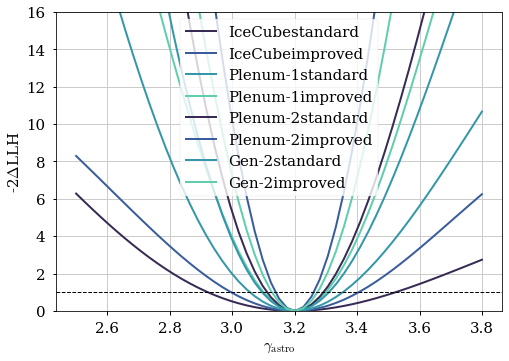

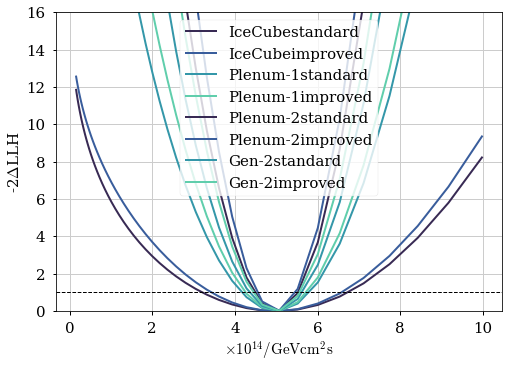

In [43]:
plt.figure()
for ident in local_SPL_gamma_scan["ts"].keys(): #idents:
    # mask invalid values where the fit failed
    mask = np.ones_like(local_SPL_gamma_scan["ts"][ident], dtype=bool)
    #mask = local_SPL_gamma_scan["ts"][ident] >= bf_SPL["ts"][ident]
    plt.plot(
        gamma_astro_scaling[mask],
        local_SPL_gamma_scan["ts"][ident][mask] - bf_SPL["ts"][ident],
        label=ident,
    )
plt.axhline(1, ls="--", color="k", lw=1)
plt.ylim(0, 16)
#plt.xlim(2.1, 2.4)
plt.legend(loc="upper center")
plt.xlabel(r"$\gamma_{\rm astro}$")
plt.ylabel(r"-2$\Delta$LLH")

plt.figure()
for ident in local_SPL_phi_scan["ts"].keys(): #idents:
    # mask invalid values where the fit failed
    mask = np.ones_like(local_SPL_phi_scan["ts"][ident], dtype=bool)
    #mask = local_SPL_gamma_scan["ts"][ident] >= bf_SPL["ts"][ident]
    plt.plot(
        astro_scaling[mask] * (PHI_NGC * 1E14),
        local_SPL_phi_scan["ts"][ident][mask] - bf_SPL["ts"][ident],
        label=ident,
    )
plt.axhline(1, ls="--", color="k", lw=1)
plt.ylim(0, 16)
plt.legend(loc="upper center")
plt.xlabel(r"$\times 10^{14} / \rm GeV cm^2 s$")
plt.ylabel(r"-2$\Delta$LLH")


## 2D scan - parameters of 10yr PS Paper

IceCube
Asimov data sum:
Background: 479.55085343059574
Signal: 79.47365242225797
bf param: [1.00014176 3.20014951 0.9995398 ]
starting local fits...
done
Plenum-1
Asimov data sum:
Background: 2013.974104006386
Signal: 335.8922827691626
bf param: [0.99999832 3.20001565 1.00001539]
starting local fits...
done
Plenum-2
Asimov data sum:
Background: 5119.902171630979
Signal: 850.6227767910163
bf param: [0.99999973 3.20004217 1.00002903]
starting local fits...
done
IceCube
Plenum-1
Plenum-2


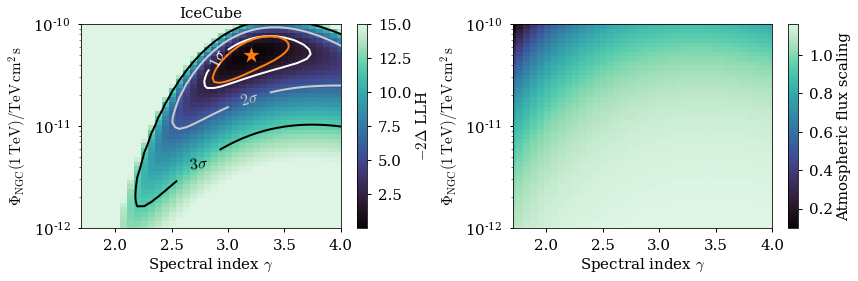

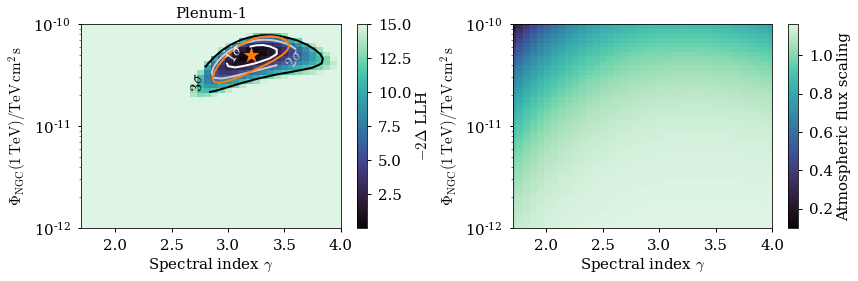

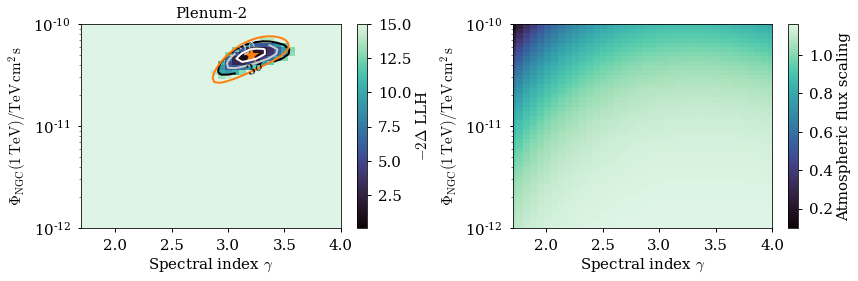

In [46]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 50
gamma_astro_scaling = np.linspace(1.7, 4.8, num=num + 1)
astro_scaling = np.logspace(-1.7, 0.5, num=num)
bf_SPL = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}}
local_SPL = {"ts": {}, "conv": {}}
shape = "powerlaw"


for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids)
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

    aeff_factor_signal = (
        array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids) * LIVETIME * ewidth * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids) * LIVETIME * ewidth * e_psi2_grid
        )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(aeff_factor_bckg, array_source_interp(ngc1068.dec.rad, spl_vals.T, sindec_mids).T)
    k_s = astro_flux(
        "powerlaw", aeff_factor_signal, emids, E0_NGC, GAMMA_NGC, 1, phi_0=PHI_NGC
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))

    dct = dict(
            mu_b_base=mu_b_base,
            mu_s_base=mu_s_base,
            k_i=k_i,
            e_0=E0_NGC,
            phi_0=PHI_NGC,
            normed_kvals=normed_kvals,
            src_dec=ngc1068.dec.rad,
        )
    global_llh = lambda x: ps_llh_2d_composite(
            x, shape="powerlaw", **dct
    )
    ## global minimum
    out = fmin_l_bfgs_b(
        global_llh,
        x0=(1.2, 2.8, 1.2),
        approx_grad=True,
    )
    if out[2]["warnflag"] != 0:
        print("WARNING!!")
    print("bf param:", out[0])

    bf_SPL["ts"][ident] = out[1]
    bf_SPL["conv"][ident] = out[0][0]
    bf_SPL["gamma"][ident] = out[0][1]
    bf_SPL["phi_astro"][ident] = out[0][2]

    local_SPL["ts"][ident] = np.zeros((num, num + 1))
    local_SPL["conv"][ident] = np.zeros((num, num + 1))
    print("starting local fits...")
    for i, asc in enumerate(astro_scaling):
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed gamma and phi_astro
            local_llh = lambda x: ps_llh_2d_composite(
                (x[0], gas, asc), shape="powerlaw", **dct
            )
            local_out = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2,),
                bounds=[(0.1, 3)],
                approx_grad=True,
            )
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])
            (local_SPL["conv"][ident][i][j],) = local_out[0]
            local_SPL["ts"][ident][i][j] = local_out[1]
    print("done")


ref_color = "tab:orange"
# confidence levels
cvals = 1 - erf(np.arange(1, 4) / np.sqrt(2))
levels = chi2.isf(cvals, 2)
lbs = np.array([r"$1\sigma$", r"$2\sigma$", r"$3\sigma$"])
level_colors = ["w", "0.8", "k"]

for ident in idents:
    print(ident)
    f, axes = plt.subplots(ncols=2, figsize=(12, 4))
    ax = axes[0]
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        gamma_astro_scaling,
        astro_scaling * PHI_NGC * 1e3,  # match 10yr paper plot
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        vmax=15,  # 6 is approx. the 95% quantile of a 2D LLH scan
    )
    cb = plt.colorbar(im, ax=ax)
    # draw contour levels

    sc = ax.contour(
        gamma_astro_scaling,
        astro_scaling * PHI_NGC * 1e3,  # match 10yr paper plot
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        levels=levels,
        colors=level_colors,
    )
    ## best fit point
    ax.scatter(
        bf_SPL["gamma"][ident],
        bf_SPL["phi_astro"][ident]
        * PHI_NGC
        * 1e3,  # match 10yr paper plot
        marker="*",
        s=250,
        color="tab:orange",
    )
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    ax.plot(
        gamma_c_68,
        phi_c_68,
        color=ref_color,
        label=r"ngc paper",
    )
    # ax.legend(loc=2)
    ax.set_ylabel(r"$\Phi_{\rm NGC} (1\,{\rm TeV}) / {\rm TeV\, cm^2\, s}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(ident)
    ax.set_yscale("log")
    ax.set_ylim(1e-12, 1e-10)
    ax.set_xlim(1.7, 4)

    # in addition, check the nuisance parameter of conventional flux
    ax = axes[1]
    im = ax.pcolormesh(
        gamma_astro_scaling,
        astro_scaling * PHI_NGC * 1e3,  # match 10yr paper plot of Tessa C.
        local_SPL["conv"][ident],
    )
    ax.set_ylabel(r"$\Phi_{\rm NGC} (1\,{\rm TeV}) / {\rm TeV\, cm^2\, s}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Atmospheric flux scaling")
    ax.set_yscale("log")
    ax.set_ylim(1e-12, 1e-10)
    ax.set_xlim(1.7, 4)

    f.tight_layout()
    f.savefig(f"../plots/2D_scan_ngc_spl_{ident}.pdf")


## Power law vs. Power-law with cutoff
### normal vs. improved E resolution

In [47]:
# livetime relative to 10yrs
detector_configurations = [
{"idx":  0, "identifier": "10y IC", "e_file": '../resources/artificial_energy_smearing_kde.pckl', "E_res": "Baseline"},
{"idx":  1, "identifier": "10y IC", "e_file": '../resources/idealized_artificial_energy_smearing_kde.pckl', "E_res": "Removed bias"},
{"idx":  2, "identifier": "10y IC", "e_file": '../resources/improved_0.1_artificial_energy_smearing_kde.pckl', "E_res": "x 10% improv."},
{"idx":  3, "identifier": "10y IC", "e_file": '../resources/improved_0.5_artificial_energy_smearing_kde.pckl', "E_res": "x 50% improv."},
{"idx":  4, "identifier": "10y IC + 10y PL-1", "e_file": '../resources/artificial_energy_smearing_kde.pckl', "E_res": "Baseline"},
{"idx":  5, "identifier": "10y IC + 10y PL-1", "e_file": '../resources/idealized_artificial_energy_smearing_kde.pckl', "E_res": "Removed bias"},
{"idx":  6, "identifier": "10y IC + 10y PL-1", "e_file": '../resources/improved_0.1_artificial_energy_smearing_kde.pckl', "E_res": "x 10% improv."},
{"idx":  7, "identifier": "10y IC + 10y PL-1", "e_file": '../resources/improved_0.5_artificial_energy_smearing_kde.pckl', "E_res": "x 50% improv."},
{"idx":  8, "identifier": "10y IC + 10y PL-2", "e_file": '../resources/artificial_energy_smearing_kde.pckl', "E_res": "Baseline"},
{"idx":  9, "identifier": "10y IC + 10y PL-2", "e_file": '../resources/idealized_artificial_energy_smearing_kde.pckl', "E_res": "Removed bias"},
{"idx": 10, "identifier": "10y IC + 10y PL-2", "e_file": '../resources/improved_0.1_artificial_energy_smearing_kde.pckl', "E_res": "x 10% improv."},
{"idx": 11, "identifier": "10y IC + 10y PL-2", "e_file": '../resources/improved_0.5_artificial_energy_smearing_kde.pckl', "E_res": "x 50% improv."},
]
detector_configurations = pd.DataFrame(detector_configurations)

### Significance

In [81]:
pvals_ngc = []
for (identifier, es_ident), series in detector_configurations.groupby(
    ["identifier", "E_res"]
):
    print(es_ident, identifier)
    aeff_factor_bckg = (
        array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids)
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    )
    aeff_factor_signal = (
        array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids)
        * LIVETIME
        * ewidth
    )
    if "PL-1" in identifier:
        ikey = "Plenum-1"
    elif "PL-2" in identifier:
        ikey = "Plenum-2"
    else:
        ikey = False
    if ikey:
        aeff_factor_bckg += (
            array_source_interp(ngc1068.dec.rad, aeff_2d[ikey], sindec_mids)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        )
        aeff_factor_signal += (
            array_source_interp(ngc1068.dec.rad, aeff_2d[ikey], sindec_mids)
            * LIVETIME
            * ewidth
        )

    aeff_factor_bckg = aeff_factor_bckg * bckg_grid
    aeff_factor_signal = aeff_factor_signal * e_psi2_grid

    print(series.e_file.iloc[0])
    # energy smearing matrix
    with open(series.e_file.iloc[0], "rb") as f:
        nkv, _ = pickle.load(f)
    # normalize per bin in true energy
    nkv = nkv / np.sum(nkv, axis=0)
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(ngc1068.dec.rad, spl_vals.T, sindec_mids).T,
        normed_kvals=nkv,
    )
    k_s = astro_flux(
        "powerlaw with cutoff",
        aeff_factor_signal,
        emids,
        E0_NGC,
        Gamma_cut,
        flux_scaling_cut,
        logE_cut,
        phi_0=PHI_NGC,
        normed_kvals=nkv,
    )
    k_i = k_s + k_b

    if ii == 0:
        print(
            "Asimov data sum: Background =", np.sum(k_b), ", Signal =", np.sum(k_s)
        )
    dct = dict(
        mu_b_base=mu_b_base,
        mu_s_base=mu_s_base,
        k_i=k_i,
        e_0=E0_NGC,
        phi_0=PHI_NGC,
        normed_kvals=nkv,
        src_dec=ngc1068.dec.rad,
    )
    pl_func = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.2, 3.0, 1.2),
        approx_grad=True,
    )
    print("bckg params:", out_bckg[0])

    comp = lambda x: ps_llh_2d_composite(x, shape="powerlaw with cutoff", **dct)
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 1.9, 1.1, 3.4),
        approx_grad=True,
    )
    print("global params:", out_comp[0])
    print("true params:", (1, Gamma_cut, flux_scaling_cut, logE_cut))

    # check the LLH at the "correct" parameter position
    check = comp((1, Gamma_cut, flux_scaling_cut, logE_cut))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    significance = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print("pval check:", pval_check, "ratio:", pval_check / pval)
    print("")
    pvals_ngc.append(
        {
            "identifier": identifier,
            "e_smearing": es_ident,
            "idx": series.idx.values[0],
            "pval": pval,
            r"Significance in $\sigma$": significance,
        }
    )


Baseline 10y IC
../resources/artificial_energy_smearing_kde.pckl
bckg params: [0.97587903 3.18266948 1.13961202]
global params: [1.00136882 1.82402082 0.95363028 3.61792051]
true params: (1, 2.0, 0.9676925453516532, 3.7)
P-VALUE: 0.4495191155110737 SIGNIFICANCE: 0.756216977250752
pval check: 0.4491475739801687 ratio: 0.9991734688957942

Removed bias 10y IC
../resources/idealized_artificial_energy_smearing_kde.pckl
bckg params: [0.99024581 3.00157178 0.96284511]
global params: [1.00202049 1.85131473 0.95531976 3.62764647]
true params: (1, 2.0, 0.9676925453516532, 3.7)
P-VALUE: 0.1457914196243357 SIGNIFICANCE: 1.4545588877938742
pval check: 0.14499106251819635 ratio: 0.9945102591894527

x 10% improv. 10y IC
../resources/improved_0.1_artificial_energy_smearing_kde.pckl
bckg params: [0.9902325  3.00164304 0.96296703]
global params: [1.00207011 1.85435408 0.95450942 3.62930561]
true params: (1, 2.0, 0.9676925453516532, 3.7)
P-VALUE: 0.13402068610007467 SIGNIFICANCE: 1.498433392204064
pval c

## Nice significance summary plot

In [83]:
pval_df = pd.DataFrame(pvals_ngc).sort_values("idx")

In [84]:
contour_formats = {
    "IceCube": {"colors": [poles["IceCube"]["color"]], "linestyles": "--"},
    "Plenum-1": {"colors": [poles["Plenum-1"]["color"]], "linestyles": poles["Plenum-1"]["ls"]},
    "Plenum-2": {"colors": [poles["Plenum-2"]["color"]], "linestyles": poles["Plenum-2"]["ls"]},
}

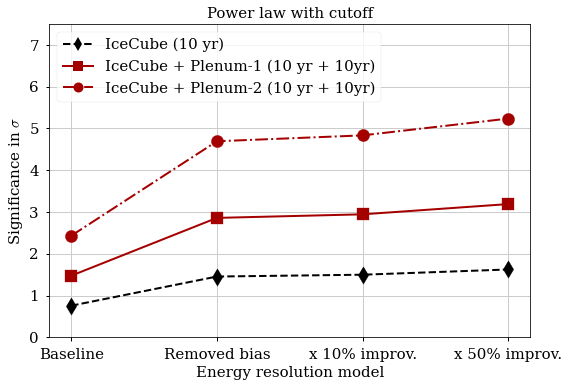

In [85]:
### plot significance vs livetime/detector configs
f, ax = plt.subplots()
label_size = "x-small"
# ICECUBE
mask = pval_df.identifier == "10y IC"
ax.plot(
    pval_df.loc[mask]["e_smearing"],
    pval_df.loc[mask][r"Significance in $\sigma$"],
    ls=contour_formats["IceCube"]["linestyles"],
    color=poles["IceCube"]["color"],
    marker="d",
    label="IceCube (10 yr)",
    ms=10,
)
ax.scatter(
    x=pval_df.loc[mask]["e_smearing"],
    y=pval_df.loc[mask][r"Significance in $\sigma$"],
    c=poles["IceCube"]["color"],
    s=150,
    zorder=10,
    marker="d",
)


## PLENUM-1
mask = pval_df.identifier == "10y IC + 10y PL-1"
ax.plot(
    pval_df.loc[mask]["e_smearing"],
    pval_df.loc[mask][r"Significance in $\sigma$"],
    ls=poles["Plenum-1"]["ls"],
    color=poles["Plenum-1"]["color"],
    marker="s",
    label="IceCube + Plenum-1 (10 yr + 10yr)",
    ms=10,
)
ax.scatter(
    x=pval_df.loc[mask]["e_smearing"],
    y=pval_df.loc[mask][r"Significance in $\sigma$"],
    c=poles["Plenum-1"]["color"],
    s=150,
    zorder=10,
    marker="s",
)


## PLENUM-2
mask = pval_df.identifier == "10y IC + 10y PL-2"
ax.plot(
    pval_df.loc[mask]["e_smearing"],
    pval_df.loc[mask][r"Significance in $\sigma$"],
    ls=poles["Plenum-2"]["ls"],
    color=poles["Plenum-2"]["color"],
    marker="o",
    label="IceCube + Plenum-2 (10 yr + 10yr)",
    ms=10,
)
ax.scatter(
    x=pval_df.loc[mask]["e_smearing"],
    y=pval_df.loc[mask][r"Significance in $\sigma$"],
    c=poles["Plenum-2"]["color"],
    s=150,
    zorder=10,
    marker="o",
)

ax.set_ylim(0, 7.5)
ax.legend(loc=2) #fontsize="x-small")
ax.set_title("Power law with cutoff")#, fontsize="small")
ax.set_xlabel("Energy resolution model")
ax.set_ylabel(r"Significance in $\sigma$")
f.tight_layout()
f.savefig("../plots/cutoff_sigma_vs_eres_ngc.pdf")


# Same for TXS 0506+056

In [86]:
with open("../resources/txs_contour.pkl", "rb") as f:
    txs_contour = pickle.load(f)

In [87]:
# PARAMETERS
GAMMA_TXS = txs_contour["best-fit"][0]
PHI_TXS = txs_contour["best-fit"][1] / 1E3 / 2.7 # fudge factor.
E0_TXS = txs_contour["E0"] 
# check the event numbers
aeff_factor_signal = (
        array_source_interp(txs0506.dec.rad, aeff_2d["IceCube"], sindec_mids) * LIVETIME * ewidth
    )
k_s = astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_TXS,
        GAMMA_TXS,
        1,
        phi_0=PHI_TXS,
    )
print(np.sum(k_s))

5.2231468523985


## Parabola: source parameters

In [88]:
# parabola parameters
Alpha_TXS = 2
Beta_TXS = 0.6
E_para_norm_TXS = 3E5


### scale the fluxes such that the event numbers match


In [89]:
aeff_factor_signal = (
    array_source_interp(txs0506.dec.rad, aeff_2d["IceCube"], sindec_mids)
    * LIVETIME
    * ewidth
)
astro_ev_sum_pl = np.sum(
    astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_TXS,
        GAMMA_TXS,
        1,
        phi_0=PHI_TXS,
    )
)

# parabola
astro_ev_sum_para = np.sum(
    astro_flux(
        "parabola",
        aeff_factor_signal,
        emids,
        E_para_norm_TXS,
        Alpha_TXS,
        1,
        Beta_TXS,
        phi_0=PHI_TXS,
    )
)
# match event numbers
flux_scaling_para_txs = astro_ev_sum_pl / astro_ev_sum_para
print("flux_scaling_para", flux_scaling_para_txs)


flux_scaling_para 0.27583531260551697



### Plot flux and event expectation


parabola 5.2231468523985
power law: 5.2231468523985


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


parabola 5.223146852398499
power law: 5.2231468523985


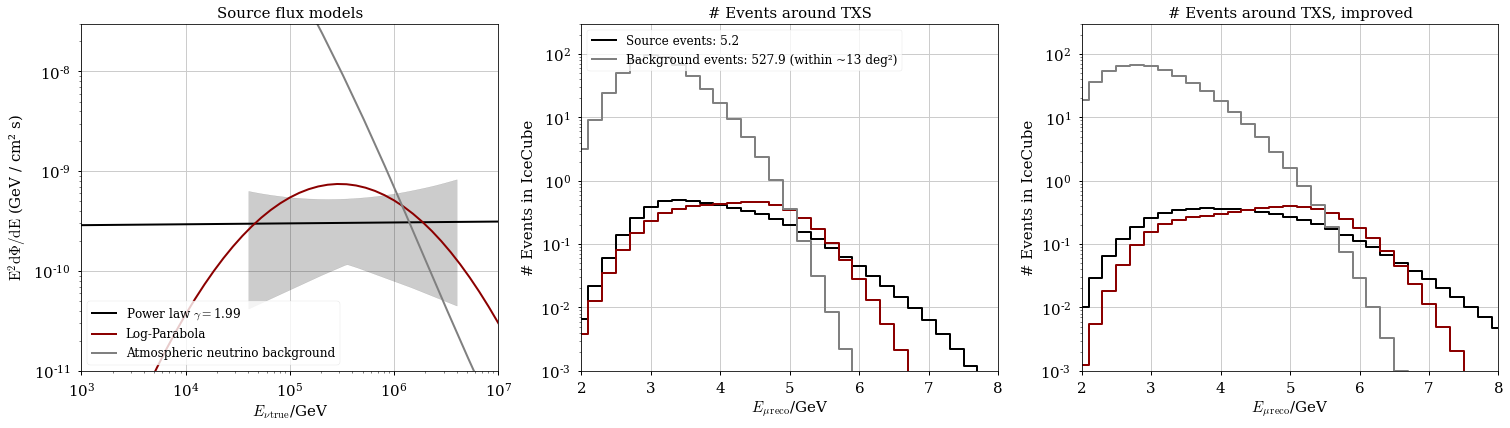

In [90]:
sq_deg = np.pi * delta_psi ** 2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

pl = power_law(x_evals, E0_TXS, GAMMA_TXS, PHI_TXS)
para_idx = parabola_index(Alpha_TXS, Beta_TXS, x_evals, E_para_norm_TXS)
para = power_law(x_evals, E_para_norm_TXS, para_idx, PHI_TXS * flux_scaling_para_txs)

f, axes = plt.subplots(ncols=3, figsize=(21, 6))
ax = axes[0]
ax.set_title("Source flux models")

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(4e4), np.log10(4e6), 100)
# without energy range interval
# x_cont = np.logspace(3, 7, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(
        xe, E0_TXS, txs_contour["68\\%"][:,0], txs_contour["68\\%"][:,1] / 1e3 / 2.8
    )  ## fudge factor :)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont ** y_scaling),
    c_high * (x_cont ** y_scaling),
    color="k",
    alpha=0.2,
)


ax.plot(
    x_evals,
    pl * (x_evals ** y_scaling),
    label=rf"Power law $\gamma=${GAMMA_TXS:1.2f}",
    color="k",
    alpha=1,
)
ax.plot(x_evals, para * (x_evals ** y_scaling), label="Log-Parabola", color="darkred")
ax.plot(
    emids,
    array_source_interp(txs0506.dec.rad, spl_vals.T, sindec_mids).T * (emids ** y_scaling),
    label="Atmospheric neutrino background",
    color="gray",
)

ax.set_yscale("log")
ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)")
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV")
ax.set_ylim(1e-11, 3e-8)
ax.set_xlim(1e3, 1e7)
ax.legend(loc=3, fontsize=12)


### plot Event numbers in E_reco
for ii, nkv in enumerate([normed_kvals, artificial_normed_kvals]):
    ax = axes[1 + ii]
    ident = "IceCube"
    aeff_factor_bckg = (
        array_source_interp(txs0506.dec.rad, aeff_2d[ident], sindec_mids)
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    )
    aeff_factor_signal = (
        array_source_interp(txs0506.dec.rad, aeff_2d[ident], sindec_mids) * LIVETIME * ewidth
    )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    use_e_reco = True
    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(txs0506.dec.rad, spl_vals.T, sindec_mids).T,
        normed_kvals=nkv,
    )

    # parabola
    k_s_para = astro_flux(
        "parabola",
        aeff_factor_signal,
        emids,
        E_para_norm_TXS,
        Alpha_TXS,
        flux_scaling_para_txs,
        Beta_TXS,
        normed_kvals=nkv,
        phi_0=PHI_TXS,
    )
    print("parabola", np.sum(k_s_para))

    # powerlaw
    k_s_pl = astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_TXS,
        GAMMA_TXS,
        1,
        normed_kvals=nkv,
        phi_0=PHI_TXS,
    )
    print("power law:", np.sum(k_s_pl))

    evals = logE_reco_mids
    _ = plot_spectrum(
        evals,
        [
            k_s_pl,
            k_s_para,
            k_b,
        ],
        [
            f"Source events: {np.sum(k_s_pl):1.1f}" if ii == 0 else "",
            "",
            f"Background events: {np.sum(k_b):1.1f} (within ~{sq_deg:1.0f} deg²)"
            if ii == 0
            else "",
        ],
        "# Events around TXS" if ii == 0 else "# Events around TXS, improved",
        f,
        ax,
        xlim=(2, 8),
        ylim=(1e-3, 3e2),
        color=["k", "darkred", "gray"],
        xlabel=r"$E_{\mu \, \rm reco}$/GeV",
        ylabel="# Events in IceCube",
    )
    if ii == 1:
        ax.get_legend().remove()
    else:
        ax.legend(loc=2, fontsize=12)

f.savefig("../plots/txs_spectral.pdf", bbox_inches="tight")


### Significances

IDEA: fix number of signal events to 5 (like seen with IceCube)
-> Vary LIVETIME of background

In [138]:
# livetime of background in days
detector_configurations = [
{"identifier": "IceCube", "livetime": 50},
{"identifier": "IceCube", "livetime": 100},
{"identifier": "IceCube", "livetime": 500},
{"identifier": "IceCube", "livetime": 1000},
{"identifier": "IceCube", "livetime": 3000},
{"identifier": "Plenum-1", "livetime": 50},
{"identifier": "Plenum-1", "livetime": 100},
{"identifier": "Plenum-1", "livetime": 500},
{"identifier": "Plenum-1", "livetime": 1000},
{"identifier": "Plenum-1", "livetime": 3000},
# {"identifier": "Plenum-2", "livetime": 50},
# {"identifier": "Plenum-2", "livetime": 100},
# {"identifier": "Plenum-2", "livetime": 500},
# {"identifier": "Plenum-2", "livetime": 1000},
# {"identifier": "Plenum-2", "livetime": 3000},
]
detector_configurations = pd.DataFrame(detector_configurations)

In [150]:
pvals_txs = []
for (identifier, livetime), series in detector_configurations.groupby(
    ["identifier", "livetime"]
):
    print(identifier, livetime, "days")
    if livetime != "full":
        livetime_bg = livetime * 24 * 3600
    else:
        livetime_bg = LIVETIME
    aeff_factor_bckg = (
        array_source_interp(txs0506.dec.rad, aeff_2d[identifier], sindec_mids)
        * livetime_bg
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    )
    aeff_factor_signal = (
        array_source_interp(txs0506.dec.rad, aeff_2d[identifier], sindec_mids)
        * LIVETIME  # we don't care about the signal livetime, it should just be a constant number of events here
        * ewidth
    )

    aeff_factor_bckg = aeff_factor_bckg * bckg_grid
    aeff_factor_signal = aeff_factor_signal * e_psi2_grid

    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(txs0506.dec.rad, spl_vals.T, sindec_mids).T,
        normed_kvals=normed_kvals,
    )
    k_s = astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_TXS,
        GAMMA_TXS,
        1,
        normed_kvals=normed_kvals,
        phi_0=PHI_TXS,
    )
    k_i = k_s + k_b
    print("Asimov data sum: Background =", np.sum(k_b), ", Signal =", np.sum(k_s))
    dct = dict(
        mu_b_base=mu_b_base,
        mu_s_base=mu_s_base,
        k_i=k_i,
        e_0=E0_TXS,
        phi_0=PHI_TXS,
        normed_kvals=normed_kvals,
        src_dec=txs0506.dec.rad,
    )
    pl_func = lambda x: ps_llh_2d_composite((x[0], 2, 0), shape="powerlaw", **dct)
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.2, 3.0, 0.1),
        approx_grad=True,
    )
    print("bckg params:", out_bckg[0])

    comp = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 1.9, 1.1),
        approx_grad=True,
    )
    print("global params:", out_comp[0])
    print("true params:", (1, GAMMA_TXS, 1))

    # check the LLH at the "correct" parameter position
    check = comp((1, GAMMA_TXS, 1))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    significance = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print("pval check:", pval_check, "ratio:", pval_check / pval)
    print("")
    pvals_txs.append(
        {
            "identifier": identifier,
            "livetime": livetime_bg / 24 / 3600,
            "pval": pval,
            r"Significance in $\sigma$": significance,
        }
    )


IceCube 50 days
Asimov data sum: Background = 2.0711899244918985 , Signal = 5.223146852398501
bckg params: [3.52155005 3.         0.1       ]
global params: [0.99995059 1.99107968 0.99959953]
true params: (1, 1.9909560723514212, 1)
P-VALUE: 6.981992612654242e-07 SIGNIFICANCE: 4.961863864364506
pval check: 6.981989529993878e-07 ratio: 0.9999995584841554

IceCube 100 days
Asimov data sum: Background = 4.142379848983797 , Signal = 5.223146852398501
bckg params: [2.26096255 3.         0.1       ]
global params: [1.00005872 1.99096201 1.00003574]
true params: (1, 1.9909560723514212, 1)
P-VALUE: 2.1397565556780646e-06 SIGNIFICANCE: 4.739756074839472
pval check: 2.1397565311595397e-06 ratio: 0.9999999885414419

IceCube 500 days
Asimov data sum: Background = 20.711899244918992 , Signal = 5.223146852398501
bckg params: [1.25216181 3.         0.1       ]
global params: [0.9999758  1.99119209 1.00003147]
true params: (1, 1.9909560723514212, 1)
P-VALUE: 6.098967134748786e-05 SIGNIFICANCE: 4.008948

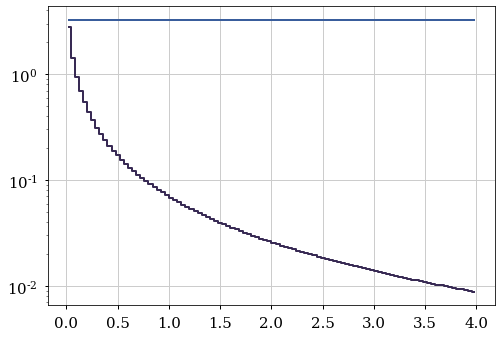

In [151]:
plt.plot(psi2_mids, k_s.sum(axis=-1), ds="steps-mid")
plt.plot(psi2_mids, k_b.sum(axis=-1), ds="steps-mid")
plt.yscale("log")

### nice plot

In [140]:
pval_df = pd.DataFrame(pvals_txs)

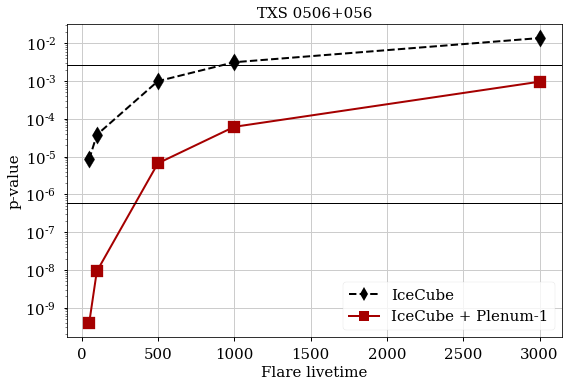

In [149]:
### plot significance vs livetime/detector configs
f, ax = plt.subplots()
label_size = "x-small"
# ICECUBE
mask = pval_df.identifier == "IceCube"
ax.plot(
    pval_df.loc[mask]["livetime"],
    pval_df.loc[mask][r"pval"],
    #pval_df.loc[mask][r"Significance in $\sigma$"],
    ls=contour_formats["IceCube"]["linestyles"],
    color=poles["IceCube"]["color"],
    marker="d",
    label="IceCube",
    ms=10,
)
ax.scatter(
    x=pval_df.loc[mask]["livetime"],
    y=pval_df.loc[mask][r"pval"],
    #y=pval_df.loc[mask][r"Significance in $\sigma$"],
    c=poles["IceCube"]["color"],
    s=150,
    zorder=10,
    marker="d",
)


## PLENUM-1
mask = pval_df.identifier == "Plenum-1"
ax.plot(
    pval_df.loc[mask]["livetime"],
    pval_df.loc[mask][r"pval"],
    #pval_df.loc[mask][r"Significance in $\sigma$"],
    ls=poles["Plenum-1"]["ls"],
    color=poles["Plenum-1"]["color"],
    marker="s",
    label="IceCube + Plenum-1",
    ms=10,
)
ax.scatter(
    x=pval_df.loc[mask]["livetime"],
    y=pval_df.loc[mask][r"pval"],
    #y=pval_df.loc[mask][r"Significance in $\sigma$"],
    c=poles["Plenum-1"]["color"],
    s=150,
    zorder=10,
    marker="s",
)


## PLENUM-2
# mask = pval_df.identifier == "Plenum-2"
# ax.plot(
#     pval_df.loc[mask]["livetime"],
#     pval_df.loc[mask][r"pval"],
#     #pval_df.loc[mask][r"Significance in $\sigma$"],
#     ls=poles["Plenum-2"]["ls"],
#     color=poles["Plenum-2"]["color"],
#     marker="o",
#     label="IceCube + Plenum-2",
#     ms=10,
# )
# ax.scatter(
#     x=pval_df.loc[mask]["livetime"],
#     y=pval_df.loc[mask][r"pval"],
#     #y=pval_df.loc[mask][r"Significance in $\sigma$"],
#     c=poles["Plenum-2"]["color"],
#     s=150,
#     zorder=10,
#     marker="o",
# )

# ax.set_ylim(0, 8)
ax.set_yscale("log")
ax.axhline(1 - erf(5 / np.sqrt(2)), lw=1, color="k")
ax.axhline(1 - erf(3 / np.sqrt(2)), lw=1, color="k")
ax.legend(loc=4) #fontsize="x-small")
ax.set_title("TXS 0506+056")#, fontsize="small")
ax.set_xlabel("Flare livetime")
ax.set_ylabel(r"p-value")
#ax.set_ylabel(r"Significance in $\sigma$")
f.tight_layout()
f.savefig("../plots/powerlaw_sigma_vs_livetime_txs.pdf")


# cutoff - 2D scan

In [33]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 50
gamma_astro_scaling = np.linspace(1, 4, num=num + 1)
cut_scaling = np.linspace(3.0, 5.0, num=num)
bf_SPL = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}, "cut": {}}
local_SPL = {"ts": {}, "conv": {}, "phi_astro": {}}
shape = "powerlaw"


for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        array_source_interp(txs0506.dec.rad, aeff_2d[ident])
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            array_source_interp(txs0506.dec.rad, aeff_2d["IceCube"])
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

    aeff_factor_signal = (
        array_source_interp(txs0506.dec.rad, aeff_2d[ident]) * LIVETIME * ewidth * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            array_source_interp(txs0506.dec.rad, aeff_2d["IceCube"]) * LIVETIME * ewidth * e_psi2_grid
        )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(aeff_factor_bckg, array_source_interp(txs0506.dec.rad, spl_vals.T).T)
    k_s = astro_flux(
        "powerlaw with cutoff",
        aeff_factor_signal,
        emids,
        E0_NGC,
        Gamma_cut,
        flux_scaling_cut,
        logE_cut,
        phi_0=PHI_NGC,
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))

    ## global minimum
    comp = lambda x: ps_llh_2d_composite(
        x, mu_b_base, mu_s_base, k_i, e_0=E0_NGC, shape="powerlaw with cutoff"
    )
    out = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 2.2, 0.5, 4.1),
        approx_grad=True,
    )
    if out[2]["warnflag"] != 0:
        print("WARNING!!")
    print("bf param:", out[0])

    bf_SPL["ts"][ident] = out[1]
    bf_SPL["conv"][ident] = out[0][0]
    bf_SPL["gamma"][ident] = out[0][1]
    bf_SPL["phi_astro"][ident] = out[0][2]
    bf_SPL["cut"][ident] = out[0][3]

    local_SPL["ts"][ident] = np.zeros((num + 1, num))
    local_SPL["conv"][ident] = np.zeros((num + 1, num))
    local_SPL["phi_astro"][ident] = np.zeros((num + 1, num))
    print("starting local fits...")
    for j, csc in enumerate(cut_scaling):
        for i, gsc in enumerate(gamma_astro_scaling):
            func = lambda x: ps_llh_2d_composite(
                (x[0], gsc, x[1], csc),
                mu_b_base,
                mu_s_base,
                k_i,
                e_0=E0_NGC,
                shape="powerlaw with cutoff",
            )
            local_out = fmin_l_bfgs_b(
                func,
                x0=(1.2, 0.5),
                bounds=[(0.1, 3), (0.01, 6)],
                approx_grad=True,
            )
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])
            local_SPL["conv"][ident][i][j] = local_out[0][0]
            local_SPL["phi_astro"][ident][i][j] = local_out[0][1]
            local_SPL["ts"][ident][i][j] = local_out[1]
    print("done")


IceCube
Asimov data sum:
Background: 601.8278832251033
Signal: 99.91740863596021
bf param: [0.9977295  2.38312148 1.27185662 3.72811385]
starting local fits...
done
Plenum-1
Asimov data sum:
Background: 2394.2184505947894
Signal: 387.8047784109814
bf param: [0.99746179 2.38675817 1.25296515 3.73978997]
starting local fits...
done
Plenum-2
Asimov data sum:
Background: 6292.103525797712
Signal: 1034.94424590785
bf param: [0.99998976 2.00205148 1.4322355  3.50094301]
starting local fits...
done


IceCube
Plenum-1
Plenum-2


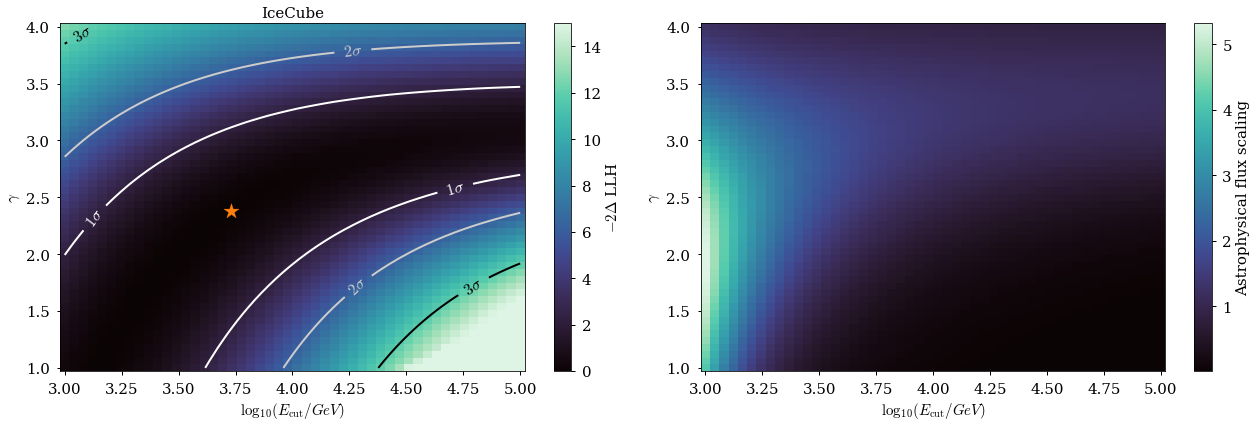

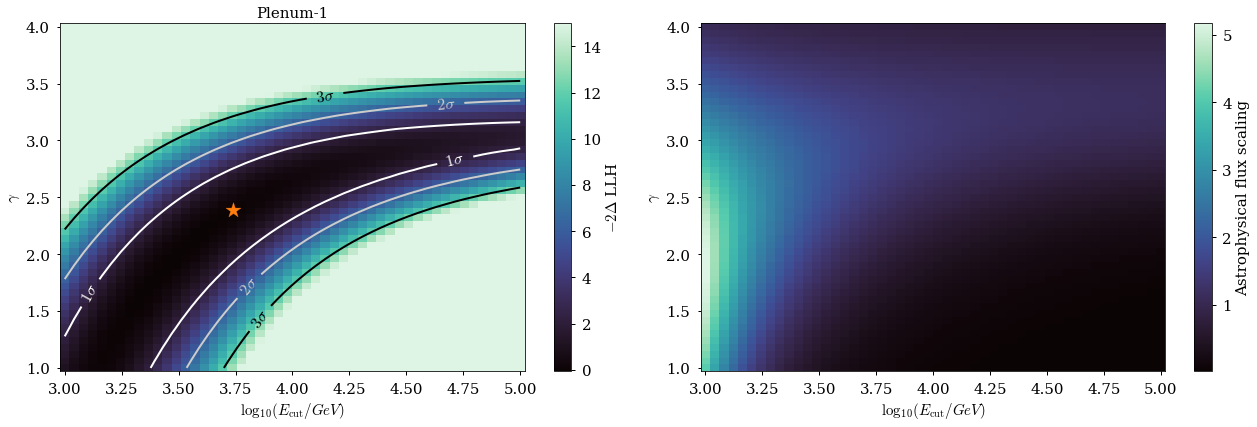

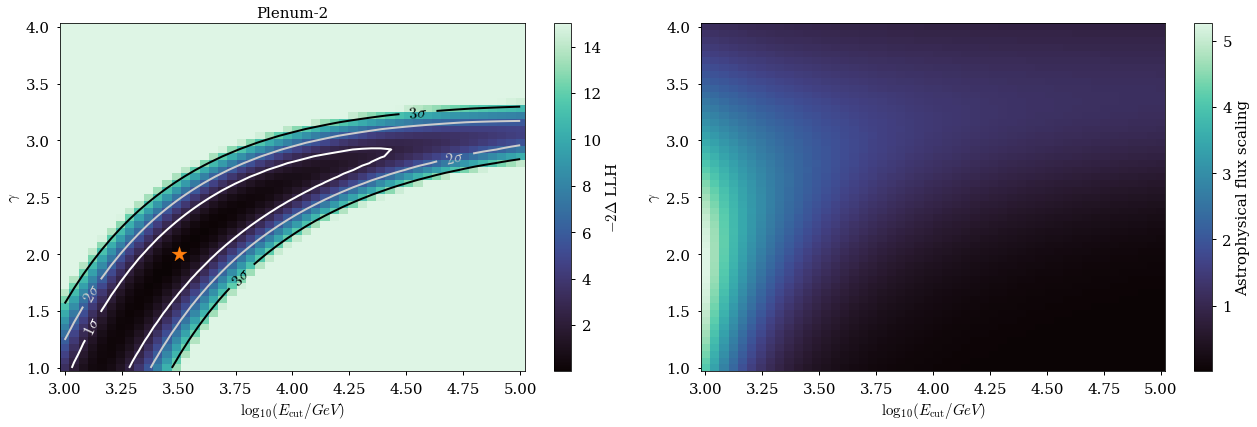

In [34]:
# confidence levels
cvals = 1 - erf(np.arange(1, 4) / np.sqrt(2))
levels = chi2.isf(cvals, 2)
lbs = np.array([r"$1\sigma$", r"$2\sigma$", r"$3\sigma$"])
level_colors = ["w", "0.8", "k"]

for ident in idents:
    print(ident)
    f, axes = plt.subplots(ncols=2, figsize=(18, 6))
    ax = axes[0]
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        cut_scaling,
        gamma_astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        vmax=15,  # 6 is approx. the 95% quantile of a 2D LLH scan
    )
    cb = plt.colorbar(im, ax=ax)
    # draw contour levels

    sc = ax.contour(
        cut_scaling,
        gamma_astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        levels=levels,
        colors=level_colors,
    )
    ## best fit point
    ax.scatter(
        bf_SPL["cut"][ident],
        bf_SPL["gamma"][ident],
        marker="*",
        s=250,
        color="tab:orange",
    )
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    ax.set_xlabel(r"$\log_{10}(E_{\rm cut} / GeV)$")
    ax.set_ylabel(r"$\gamma$")
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(ident)
    # ax.set_yscale("log")
    # ax.set_xscale("log")
    
    #ax.set_ylim(1e-12, 1e-10)
    #ax.set_xlim(1.7, 4)

    # in addition, check the "nuisance" parameter of astro flux normalization
    ax = axes[1]
    im = ax.pcolormesh(
        cut_scaling,
        gamma_astro_scaling,
        local_SPL["phi_astro"][ident],
    )
    ax.set_xlabel(r"$\log_{10}(E_{\rm cut} / GeV)$")
    ax.set_ylabel(r"$\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Astrophysical flux scaling")
    # ax.set_yscale("log")
    # ax.set_xscale("log")
    
    #ax.set_ylim(1e-12, 1e-10)
    #ax.set_xlim(1.7, 4)

    f.tight_layout()
    # f.savefig(f"../plots/2D_scan_diffuse_spl_{ident}.pdf")


# Cross check with toy model fitting

In [27]:
from scipy.stats import poisson

In [28]:
ef = '../resources/energy_smearing_kde.pckl'
# energy smearing matrix
with open(ef, "rb") as f:
    nkv, logE_reco_bins = pickle.load(f)
# normalize per bin in true energy
nkv = nkv / np.sum(nkv, axis=0)
logE_reco_mids = get_mids(logE_reco_bins)
es_ident = ef.split("/")[-1].split("_energy")[0]
print(es_ident)

energy_smearing_kde.pckl


In [29]:
# idents = ["IceCube", "Plenum-1", "Plenum-2"] #, "Gen-2"]
ident = "Plenum-1"
print(ident)

aeff_factor_bckg = (
    aeff_2d[ident][:, ngc_bin_index]
    * LIVETIME
    * ewidth
    * (np.deg2rad(delta_psi) ** 2)
    * np.pi  # solid angle approx.
) * bckg_grid
if "Plenum" in ident:
    aeff_factor_bckg += (
        aeff_2d["IceCube"][:, ngc_bin_index]
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid

aeff_factor_signal = (
    aeff_2d[ident][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
)
if "Plenum" in ident:
    aeff_factor_signal += (
        aeff_2d["IceCube"][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
    )
    
# model expectation for fitting
mu_b_base = deepcopy(aeff_factor_bckg)
mu_s_base = deepcopy(aeff_factor_signal)

# asimov data
k_b = atmo_background(
    aeff_factor_bckg, spl_vals[ngc_bin_index], normed_kvals=nkv
)
k_s = astro_flux(
    "powerlaw",
    aeff_factor_signal,
    emids,
    E0_NGC,
    GAMMA_NGC,
    1,
    phi_0=PHI_NGC,
    normed_kvals=nkv,
)
k_baseline = k_s + k_b

num = 100
ts = np.zeros(num)
ts_check = np.zeros(num)

for ii in range(num):
    k_i = poisson.rvs(k_baseline)

    pl_func = lambda x: ps_llh_2d_composite(
        x, mu_b_base, mu_s_base, k_i, shape="powerlaw", normed_kvals=nkv
    )
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.2, 3.0, 1.2),
        bounds=((0.2, 12), (1, 5), (0.2, 12)),
        approx_grad=True,
    )
    #print("bckg params:", out_bckg[0])

    comp = lambda x: ps_llh_2d_composite(
        x,
        mu_b_base,
        mu_s_base,
        k_i,
        e_0=E0_NGC,
        shape="powerlaw with cutoff",
        normed_kvals=nkv,
    )
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 2.2, 1, 3.3),
        bounds=((0.2, 12), (1, 5), (0.2, 4), (1, 20)),
        approx_grad=True,
    )
    #print("global params:", out_comp[0])
    #print("true params (background hypothesis):", (1, GAMMA_NGC, 1))

    # check the LLH at the "correct" parameter position
    ts[ii] = pl_func((1, GAMMA_NGC, 1)) - out_comp[1]
    ts_check[ii] = out_bckg[1] - out_comp[1]
    #pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    #pval_check = chi2.sf(out_bckg[1] - check, 1)
    #significance = erfinv(1 - pval) * np.sqrt(2)
    #print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    #print("pval check:", pval_check, "ratio:", pval_check / pval)
    #print("")


Plenum-1


<AxesSubplot:ylabel='Count'>

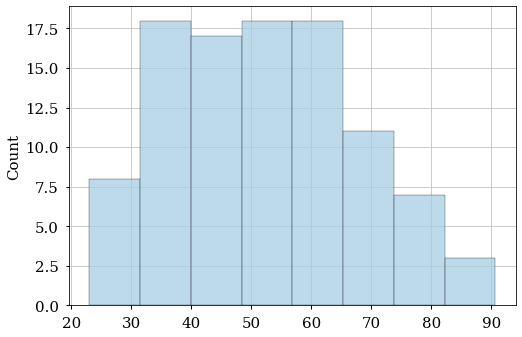

In [30]:
sns.histplot(ts)

<AxesSubplot:ylabel='Count'>

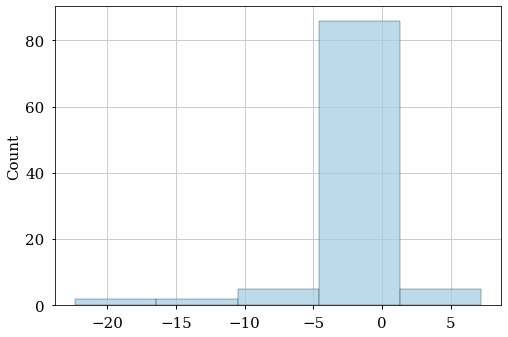

In [31]:
sns.histplot(ts_check, bins=5)